In [3]:
"""
Formula 1 Race Prediction Model
- This notebook scrapes F1 data from Ergast API
- Creates ML models to predict race results
- Includes multiple model types (Random Forest, XGBoost, Neural Network)
- Visualizes race predictions and model performance
"""

'\nFormula 1 Race Prediction Model\n- This notebook scrapes F1 data from Ergast API\n- Creates ML models to predict race results\n- Includes multiple model types (Random Forest, XGBoost, Neural Network)\n- Visualizes race predictions and model performance\n'

In [4]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost tensorflow requests

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


In [6]:
# Set Matplotlib style for better visualizations
plt.style.use('fivethirtyeight')
sns.set_palette("bright")
sns.set_context("notebook", font_scale=1.2)


# Data collection

In [7]:
# Formula 1 Race Prediction Model

# Function to fetch data from Ergast API
def fetch_ergast_data(endpoint, params=None):
    """Fetch data from Ergast API with error handling."""
    base_url = "http://ergast.com/api/f1"
    url = f"{base_url}/{endpoint}.json"

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None

# Fetch season list (last 10 seasons)
def get_seasons(limit=10):
    """Get the last specified number of F1 seasons."""
    current_year = 2024  # Assuming current knowledge cutoff
    seasons = list(range(current_year-limit+1, current_year+1))
    return seasons

# Data collection functions
def get_race_results(season, race=None):
    """Get race results for a season or specific race."""
    endpoint = f"{season}"
    if race:
        endpoint += f"/{race}"
    endpoint += "/results"
    data = fetch_ergast_data(endpoint, {"limit": 1000})

    if not data:
        return pd.DataFrame()

    races = []

    # Extract race data
    race_table = data["MRData"]["RaceTable"]["Races"]
    for race in race_table:
        race_name = race["raceName"]
        circuit_name = race["Circuit"]["circuitName"]
        date = race["date"]

        for result in race["Results"]:
            driver_id = result["Driver"]["driverId"]
            driver_name = f"{result['Driver']['givenName']} {result['Driver']['familyName']}"
            constructor = result["Constructor"]["name"]

            # Get finishing position
            if "position" in result:
                position = int(result["position"])
            else:
                position = None

            # Get grid position
            if "grid" in result:
                grid = int(result["grid"])
            else:
                grid = None

            # Get status (finished/DNF reason)
            status = result["status"]

            # Get points
            points = float(result["points"])

            # Get fastest lap info if available
            fastest_lap_rank = None
            fastest_lap_time = None
            if "FastestLap" in result:
                fastest_lap_rank = int(result["FastestLap"]["rank"])
                if "Time" in result["FastestLap"]:
                    fastest_lap_time = result["FastestLap"]["Time"]["time"]

            races.append({
                "season": season,
                "race_name": race_name,
                "circuit": circuit_name,
                "date": date,
                "driver_id": driver_id,
                "driver_name": driver_name,
                "constructor": constructor,
                "grid": grid,
                "position": position,
                "status": status,
                "points": points,
                "fastest_lap_rank": fastest_lap_rank,
                "fastest_lap_time": fastest_lap_time
            })

    return pd.DataFrame(races)

def get_qualifying_results(season, race=None):
    """Get qualifying results for a season or specific race."""
    endpoint = f"{season}"
    if race:
        endpoint += f"/{race}"
    endpoint += "/qualifying"
    data = fetch_ergast_data(endpoint, {"limit": 1000})

    if not data:
        return pd.DataFrame()

    qualifying = []

    # Extract qualifying data
    race_table = data["MRData"]["RaceTable"]["Races"]
    for race in race_table:
        race_name = race["raceName"]
        circuit_name = race["Circuit"]["circuitName"]
        date = race["date"]

        for result in race.get("QualifyingResults", []):
            driver_id = result["Driver"]["driverId"]
            driver_name = f"{result['Driver']['givenName']} {result['Driver']['familyName']}"
            constructor = result["Constructor"]["name"]

            # Get qualifying position
            position = int(result["position"]) if "position" in result else None

            # Get Q1, Q2, Q3 times if available
            q1_time = result.get("Q1", None)
            q2_time = result.get("Q2", None)
            q3_time = result.get("Q3", None)

            qualifying.append({
                "season": season,
                "race_name": race_name,
                "circuit": circuit_name,
                "date": date,
                "driver_id": driver_id,
                "driver_name": driver_name,
                "constructor": constructor,
                "q_position": position,
                "q1_time": q1_time,
                "q2_time": q2_time,
                "q3_time": q3_time
            })

    return pd.DataFrame(qualifying)

def get_driver_standings(season, race=None):
    """Get driver standings for a season or after a specific race."""
    endpoint = f"{season}"
    if race:
        endpoint += f"/{race}"
    endpoint += "/driverStandings"
    data = fetch_ergast_data(endpoint, {"limit": 1000})

    if not data:
        return pd.DataFrame()

    standings = []

    # Extract standings data
    standings_lists = data["MRData"]["StandingsTable"]["StandingsLists"]
    for standing_list in standings_lists:
        round_num = standing_list["round"]
        season = standing_list["season"]

        for standing in standing_list["DriverStandings"]:
            position = int(standing["position"])
            points = float(standing["points"])
            wins = int(standing["wins"])
            driver_id = standing["Driver"]["driverId"]
            driver_name = f"{standing['Driver']['givenName']} {standing['Driver']['familyName']}"
            constructor = standing["Constructors"][0]["name"] if standing["Constructors"] else None

            standings.append({
                "season": season,
                "round": round_num,
                "driver_id": driver_id,
                "driver_name": driver_name,
                "constructor": constructor,
                "position": position,
                "points": points,
                "wins": wins
            })

    return pd.DataFrame(standings)

def get_constructor_standings(season, race=None):
    """Get constructor standings for a season or after a specific race."""
    endpoint = f"{season}"
    if race:
        endpoint += f"/{race}"
    endpoint += "/constructorStandings"
    data = fetch_ergast_data(endpoint, {"limit": 1000})

    if not data:
        return pd.DataFrame()

    standings = []

    # Extract standings data
    standings_lists = data["MRData"]["StandingsTable"]["StandingsLists"]
    for standing_list in standings_lists:
        round_num = standing_list["round"]
        season = standing_list["season"]

        for standing in standing_list["ConstructorStandings"]:
            position = int(standing["position"])
            points = float(standing["points"])
            wins = int(standing["wins"])
            constructor_id = standing["Constructor"]["constructorId"]
            constructor_name = standing["Constructor"]["name"]

            standings.append({
                "season": season,
                "round": round_num,
                "constructor_id": constructor_id,
                "constructor_name": constructor_name,
                "position": position,
                "points": points,
                "wins": wins
            })

    return pd.DataFrame(standings)

def get_race_info(seasons):
    """Get race schedule information for the specified seasons."""
    races = []

    for season in seasons:
        data = fetch_ergast_data(f"{season}")

        if not data:
            continue

        race_table = data["MRData"]["RaceTable"]["Races"]
        for race in race_table:
            race_num = int(race["round"])
            race_name = race["raceName"]
            circuit_name = race["Circuit"]["circuitName"]
            circuit_id = race["Circuit"]["circuitId"]
            date = race["date"]

            # Get circuit location information
            location = race["Circuit"]["Location"]
            lat = float(location["lat"])
            long = float(location["long"])
            locality = location["locality"]
            country = location["country"]

            races.append({
                "season": season,
                "round": race_num,
                "race_name": race_name,
                "circuit_name": circuit_name,
                "circuit_id": circuit_id,
                "date": date,
                "latitude": lat,
                "longitude": long,
                "locality": locality,
                "country": country
            })

    return pd.DataFrame(races)

# Data Collection
print("Collecting F1 data...")
seasons = get_seasons(limit=10)  # Last 10 seasons
print(f"Collecting data for seasons: {seasons}")

In [8]:
# Initialize DataFrames
all_race_results = pd.DataFrame()
all_qualifying = pd.DataFrame()
all_driver_standings = pd.DataFrame()
all_constructor_standings = pd.DataFrame()
race_info = get_race_info(seasons)


In [9]:
for season in seasons:
    print(f"Collecting data for season {season}...")

    # Get race results
    race_results = get_race_results(season)
    all_race_results = pd.concat([all_race_results, race_results])

    # Get qualifying results
    qualifying = get_qualifying_results(season)
    all_qualifying = pd.concat([all_qualifying, qualifying])

    # Get final driver standings for the season
    driver_standings = get_driver_standings(season)
    all_driver_standings = pd.concat([all_driver_standings, driver_standings])

    # Get final constructor standings for the season
    constructor_standings = get_constructor_standings(season)
    all_constructor_standings = pd.concat([all_constructor_standings, constructor_standings])

# Display basic info about the collected data
print(f"Collected {len(all_race_results)} race results")
print(f"Collected {len(all_qualifying)} qualifying results")
print(f"Collected {len(all_driver_standings)} driver standings")
print(f"Collected {len(all_constructor_standings)} constructor standings")
print(f"Collected {len(race_info)} race information entries")


Collected 1000 race results
Collected 1000 qualifying results
Collected 223 driver standings
Collected 101 constructor standings
Collected 209 race information entries


# Data Preprocessing

In [10]:
# Data Preprocessing
print("\nProcessing and preparing data...")

# Convert time strings to seconds
def time_to_seconds(time_str):
    if pd.isna(time_str):
        return None

    # Handle different time formats
    try:
        if ":" in time_str:
            parts = time_str.split(":")
            if len(parts) == 2:  # MM:SS.sss
                return float(parts[0]) * 60 + float(parts[1])
            elif len(parts) == 3:  # HH:MM:SS.sss
                return float(parts[0]) * 3600 + float(parts[1]) * 60 + float(parts[2])
        else:  # Just seconds
            return float(time_str)
    except:
        return None

# Process qualifying times
for col in ['q1_time', 'q2_time', 'q3_time']:
    if col in all_qualifying.columns:
        all_qualifying[f'{col}_seconds'] = all_qualifying[col].apply(time_to_seconds)

# Merge qualifying data with race results
race_qual_data = pd.merge(
    all_race_results,
    all_qualifying[['season', 'race_name', 'driver_id', 'q_position', 'q1_time_seconds', 'q2_time_seconds', 'q3_time_seconds']],
    how='left',
    on=['season', 'race_name', 'driver_id']
)

# Create features for previous performance
# Group by driver and sort by date to get performances in chronological order
race_qual_data['date'] = pd.to_datetime(race_qual_data['date'])
race_qual_data = race_qual_data.sort_values(['driver_id', 'date'])

# Create previous race performance features
race_qual_data['prev_position'] = race_qual_data.groupby('driver_id')['position'].shift(1)
race_qual_data['prev_points'] = race_qual_data.groupby('driver_id')['points'].shift(1)
race_qual_data['avg_last_3_positions'] = race_qual_data.groupby('driver_id')['position'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean().shift(1)
)
race_qual_data['avg_last_3_points'] = race_qual_data.groupby('driver_id')['points'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean().shift(1)
)

# Create circuit familiarity feature - how many times a driver has raced at this circuit
race_qual_data['circuit_races'] = race_qual_data.groupby(['driver_id', 'circuit'])['date'].transform(
    lambda x: x.expanding().count().shift(1)
)

# Add constructor performance metrics
constructor_perf = race_qual_data.groupby(['season', 'constructor']).agg(
    avg_constructor_pos=('position', 'mean'),
    avg_constructor_points=('points', 'mean')
).reset_index()

race_qual_data = pd.merge(
    race_qual_data,
    constructor_perf,
    how='left',
    on=['season', 'constructor']
)

# Create features for qualifying performance vs race result
race_qual_data['grid_to_position_change'] = race_qual_data['grid'] - race_qual_data['position']

# Add driver's experience (number of races)
race_qual_data['driver_experience'] = race_qual_data.groupby('driver_id')['date'].transform(
    lambda x: x.expanding().count().shift(1)
)

# Handle DNFs (Did Not Finish)
race_qual_data['dnf'] = race_qual_data['status'].apply(lambda x: 0 if x == 'Finished' else 1)
race_qual_data['dnf_rate'] = race_qual_data.groupby('driver_id')['dnf'].transform(
    lambda x: x.expanding().mean().shift(1)
)

# Feature engineering for race-specific factors
race_qual_data = pd.merge(
    race_qual_data,
    race_info[['season', 'race_name', 'round']],
    how='left',
    on=['season', 'race_name']
)

# Add season progress feature (which round in the season)
race_qual_data['season_progress'] = race_qual_data['round'] / race_qual_data.groupby('season')['round'].transform('max')



Processing and preparing data...


# Cleaning the dataset

In [11]:
# Clean up data
race_qual_data = race_qual_data.dropna(subset=['position', 'grid'])  # Drop rows with missing position or grid
model_data = race_qual_data.copy()

# Convert categorical features to numerical using one-hot encoding
categorical_features = ['constructor', 'circuit']
numerical_features = [
    'grid', 'q_position', 'prev_position', 'prev_points',
    'avg_last_3_positions', 'avg_last_3_points', 'circuit_races',
    'avg_constructor_pos', 'avg_constructor_points', 'driver_experience',
    'dnf_rate', 'season_progress', 'round'
]

# Clean up the dataset by filling NAs with appropriate values
for col in numerical_features:
    if col in model_data.columns:
        model_data[col] = model_data[col].fillna(model_data[col].median())

# Prepare features and target for machine learning
X = model_data[categorical_features + numerical_features].copy()
y_position = model_data['position'].astype(int)
y_points = model_data['points']


# Train/test split & preprocessing pipeline

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_pos_train, y_pos_test, y_points_train, y_points_test = train_test_split(
    X, y_position, y_points, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

Training data shape: (800, 15)
Testing data shape: (200, 15)


In [13]:
#download csv dataset
model_data.to_csv('model_data.csv', index=False)

# Model training

In [14]:
# Model 1: Random Forest for Position Prediction
print("\nTraining Random Forest model for position prediction...")
rf_position_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_position_pipeline.fit(X_train, y_pos_train)
rf_position_preds = rf_position_pipeline.predict(X_test)
rf_position_rmse = np.sqrt(mean_squared_error(y_pos_test, rf_position_preds))
rf_position_r2 = r2_score(y_pos_test, rf_position_preds)
rf_position_mae = mean_absolute_error(y_pos_test, rf_position_preds)
print(f"Random Forest Position RMSE: {rf_position_rmse:.4f}")
print(f"Random Forest Position R2: {rf_position_r2:.4f}")
print(f"Random Forest Position MAE: {rf_position_mae:.4f}")

# Model 2: XGBoost for Position Prediction
print("\nTraining XGBoost model for position prediction...")
xgb_position_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

xgb_position_pipeline.fit(X_train, y_pos_train)
xgb_position_preds = xgb_position_pipeline.predict(X_test)
xgb_position_rmse = np.sqrt(mean_squared_error(y_pos_test, xgb_position_preds))
xgb_position_r2 = r2_score(y_pos_test, xgb_position_preds)
xgb_position_mae = mean_absolute_error(y_pos_test, xgb_position_preds)
print(f"XGBoost Position RMSE: {xgb_position_rmse:.4f}")
print(f"XGBoost Position R2: {xgb_position_r2:.4f}")
print(f"XGBoost Position MAE: {xgb_position_mae:.4f}")

# Neural Network for Position Prediction
print("\nTraining Neural Network model for position prediction...")

# Process data for Neural Network
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Create Neural Network model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

nn_model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = nn_model.fit(
    X_train_processed, y_pos_train,
    epochs=50, #early stopping
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

nn_position_preds = nn_model.predict(X_test_processed).flatten()
nn_position_rmse = np.sqrt(mean_squared_error(y_pos_test, nn_position_preds))
nn_points_r2 = r2_score(y_points_test, nn_position_preds)
nn_points_mae = mean_absolute_error(y_points_test, nn_position_preds)
print(f"Neural Network Position RMSE: {nn_position_rmse:.4f}")
print(f"Neural Network Position R2: {nn_points_r2:.4f}")
print(f"Neural Network Position MAE: {nn_points_mae:.4f}")

# Model for Points Prediction
print("\nTraining XGBoost model for points prediction...")
xgb_points_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

xgb_points_pipeline.fit(X_train, y_points_train)
xgb_points_preds = xgb_points_pipeline.predict(X_test)
xgb_points_rmse = np.sqrt(mean_squared_error(y_points_test, xgb_points_preds))
xgb_points_r2 = r2_score(y_points_test, xgb_points_preds)
xgb_points_mae = mean_absolute_error(y_points_test, xgb_points_preds)
print(f"XGBoost Points RMSE: {xgb_points_rmse:.4f}")
print(f"XGBoost Points R2: {xgb_points_r2:.4f}")
print(f"XGBoost Points MAE: {xgb_points_mae:.4f}")



Training Random Forest model for position prediction...
Random Forest Position RMSE: 4.5475
Random Forest Position R2: 0.4127
Random Forest Position MAE: 3.3281

Training XGBoost model for position prediction...
XGBoost Position RMSE: 4.8227
XGBoost Position R2: 0.3394
XGBoost Position MAE: 3.5270

Training Neural Network model for position prediction...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Neural Network Position RMSE: 4.4620
Neural Network Position R2: -1.6264
Neural Network Position MAE: 10.6486

Training XGBoost model for points prediction...
XGBoost Points RMSE: 4.9511
XGBoost Points R2: 0.5643
XGBoost Points MAE: 3.1828


In [15]:
print("\nAnalyzing feature importance...")

# Get feature names after preprocessing
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numerical_features, cat_feature_names])

# Get feature importances from Random Forest model
rf_importances = rf_position_pipeline.named_steps['model'].feature_importances_

# Get XGBoost feature importances
xgb_importances = xgb_position_pipeline.named_steps['model'].feature_importances_



Analyzing feature importance...


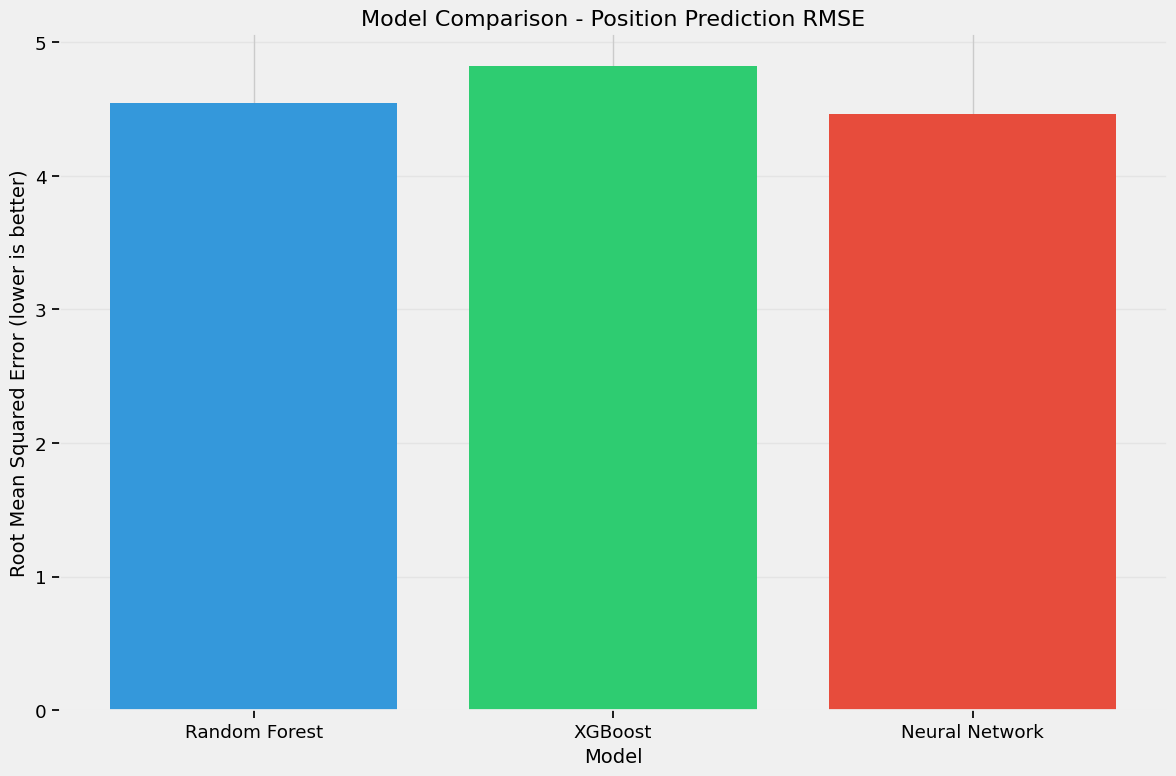

In [16]:
# 1. Model Comparison
plt.figure(figsize=(12, 8))
model_names = ['Random Forest', 'XGBoost', 'Neural Network']
position_rmse = [rf_position_rmse, xgb_position_rmse, nn_position_rmse]

plt.bar(model_names, position_rmse, color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Model Comparison - Position Prediction RMSE', fontsize=16)
plt.ylabel('Root Mean Squared Error (lower is better)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('model_comparison.png')
plt.close()


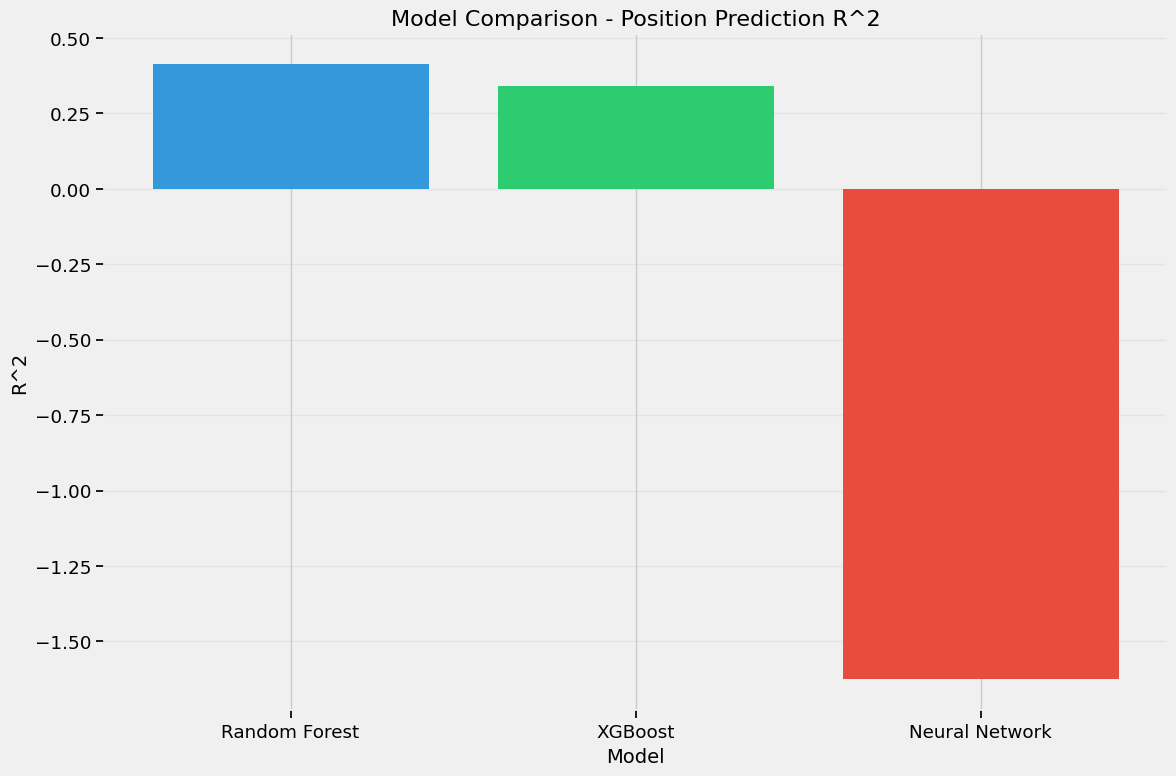

In [17]:
plt.figure(figsize=(12, 8))
model_names = ['Random Forest', 'XGBoost', 'Neural Network']
position_rmse = [rf_position_r2, xgb_position_r2, nn_points_r2]

plt.bar(model_names, position_rmse, color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Model Comparison - Position Prediction R^2', fontsize=16)
plt.ylabel('R^2' , fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('model_comparison_r2.png')
plt.close()

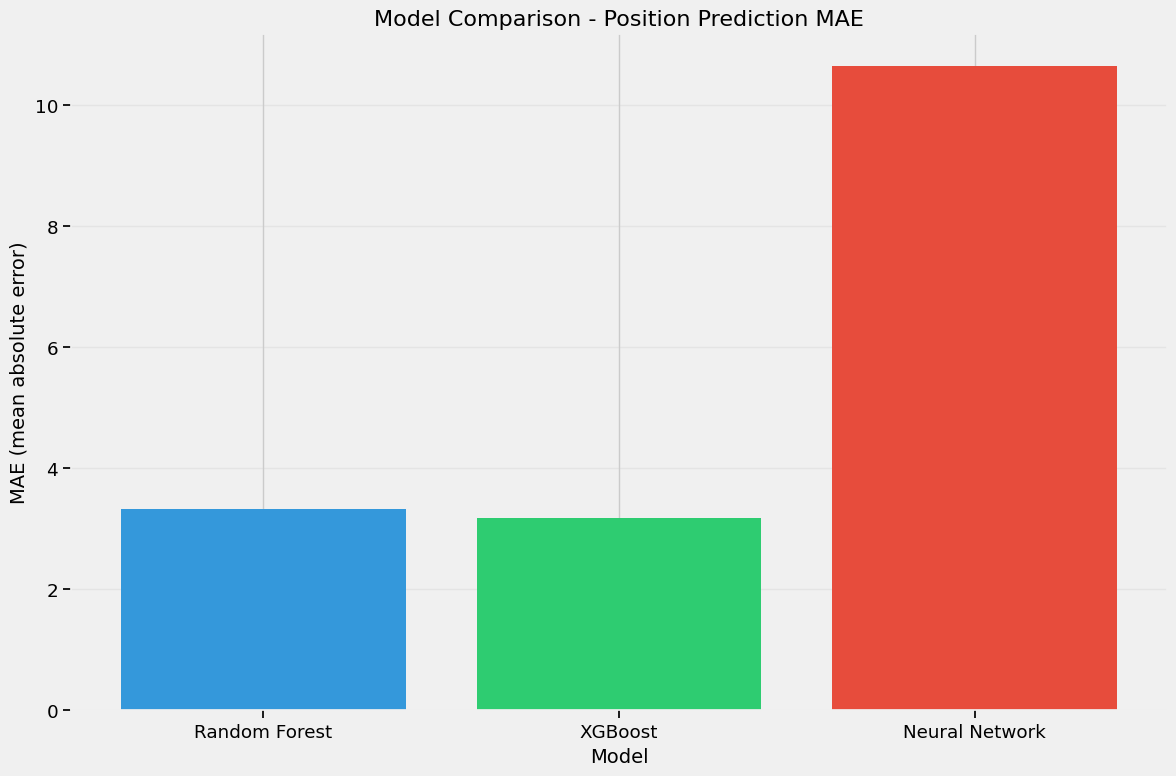

In [18]:
plt.figure(figsize=(12, 8))
model_names = ['Random Forest', 'XGBoost', 'Neural Network']
position_rmse = [rf_position_mae, xgb_points_mae, nn_points_mae]

plt.bar(model_names, position_rmse, color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Model Comparison - Position Prediction MAE', fontsize=16)
plt.ylabel('MAE (mean absolute error)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('model_comparison_mae.png')
plt.close()

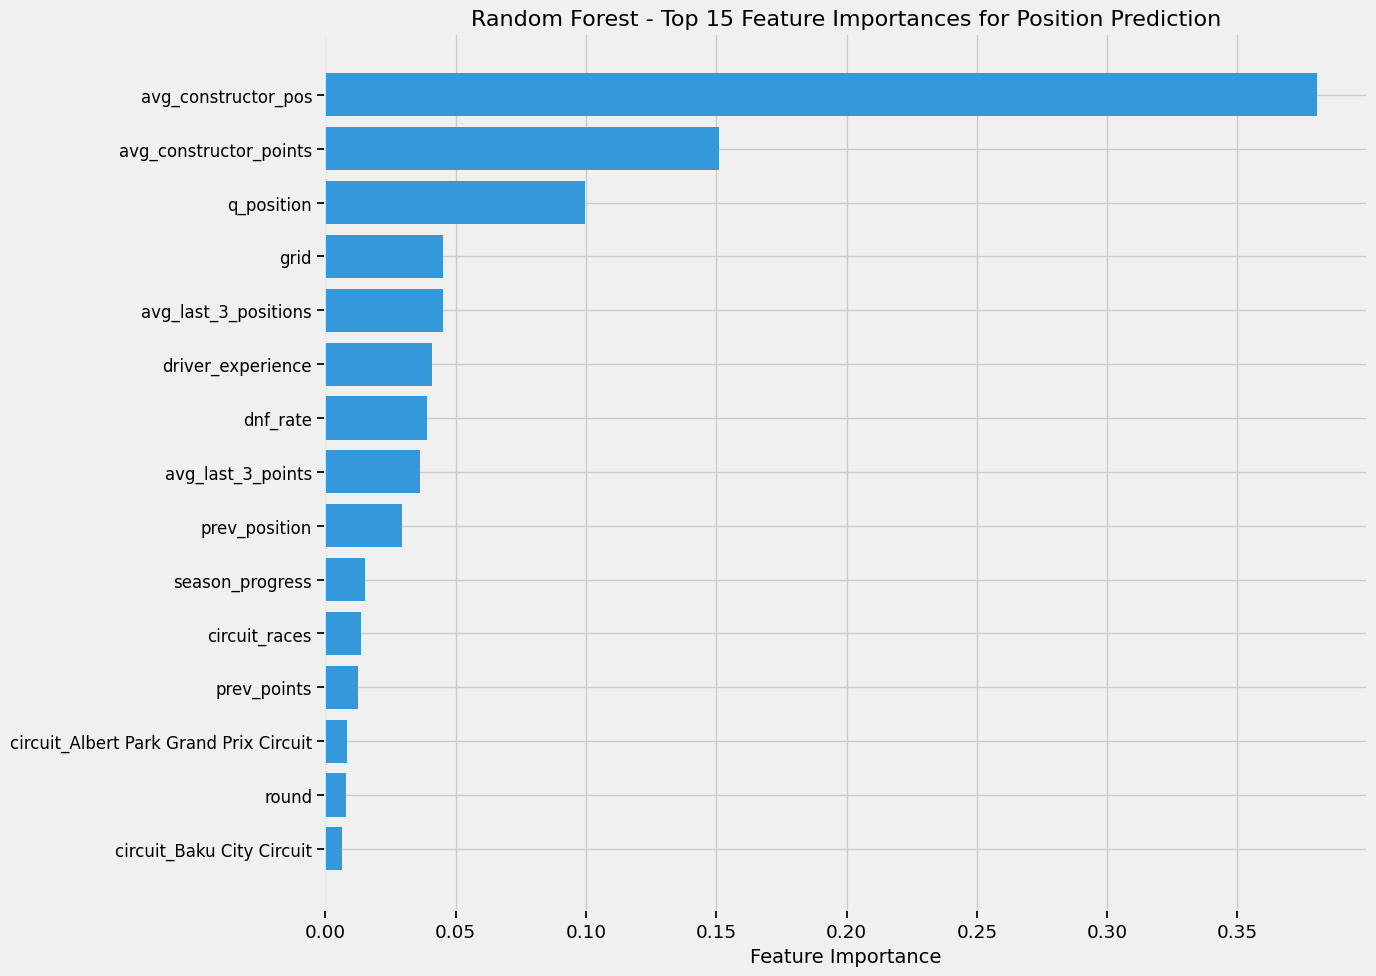

In [19]:
# 2. Feature Importance from Random Forest
plt.figure(figsize=(14, 10))
# Sort features by importance
sorted_idx = np.argsort(rf_importances)[-15:]  # Top 15 features
plt.barh(range(len(sorted_idx)), rf_importances[sorted_idx], color='#3498db')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx], fontsize=12)
plt.title('Random Forest - Top 15 Feature Importances for Position Prediction', fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.tight_layout()
plt.show()
plt.savefig('rf_feature_importance.png')
plt.close()

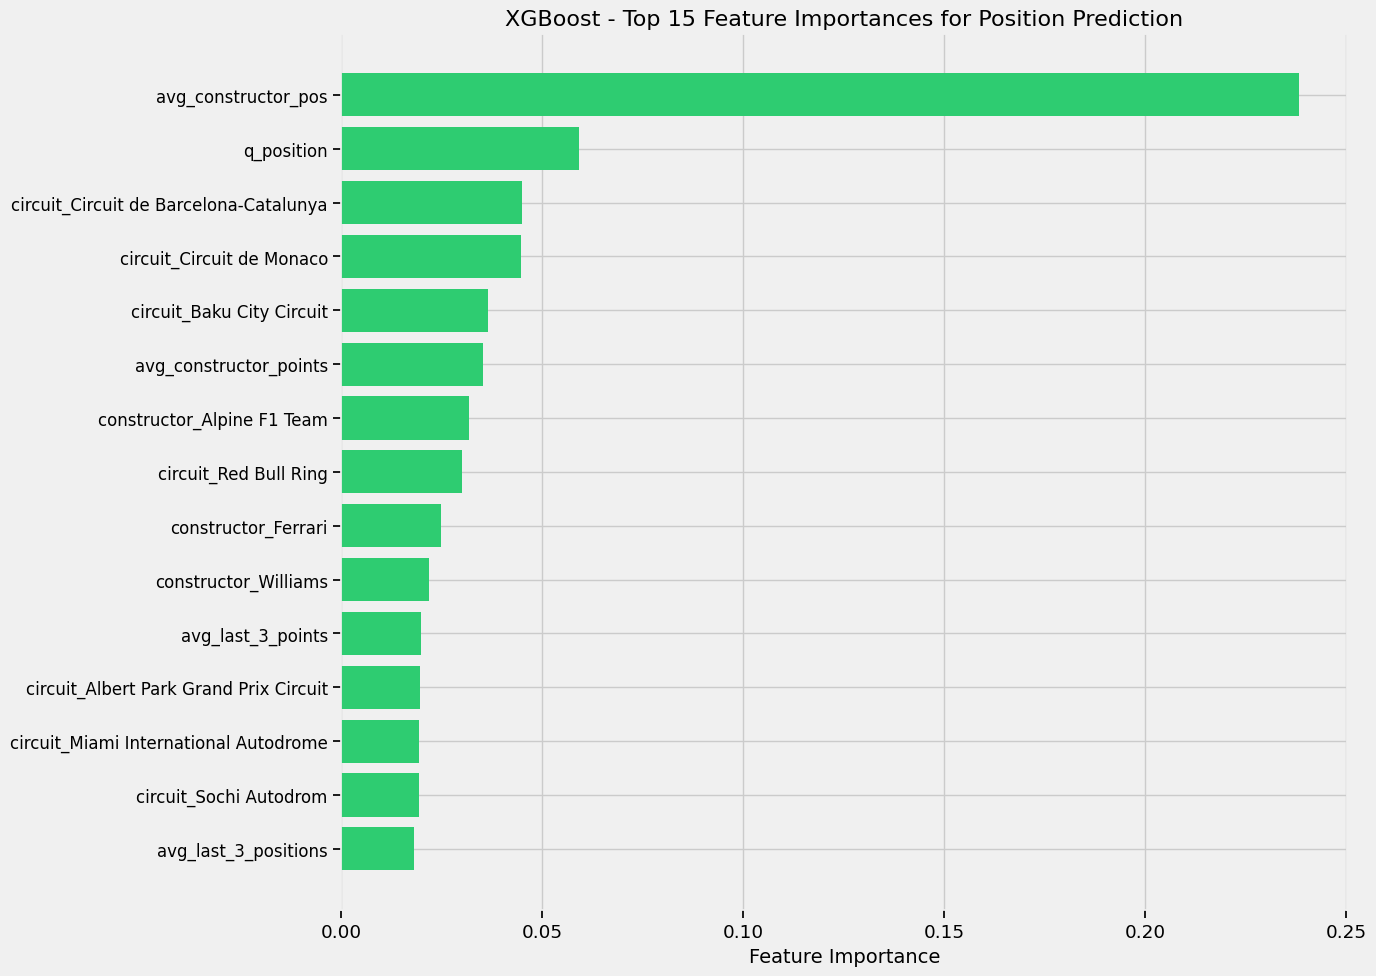

In [20]:
# 3. Feature Importance from XGBoost
plt.figure(figsize=(14, 10))
# Sort features by importance
sorted_idx = np.argsort(xgb_importances)[-15:]  # Top 15 features
plt.barh(range(len(sorted_idx)), xgb_importances[sorted_idx], color='#2ecc71')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx], fontsize=12)
plt.title('XGBoost - Top 15 Feature Importances for Position Prediction', fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.tight_layout()
plt.show()
plt.savefig('xgb_feature_importance.png')
plt.close()

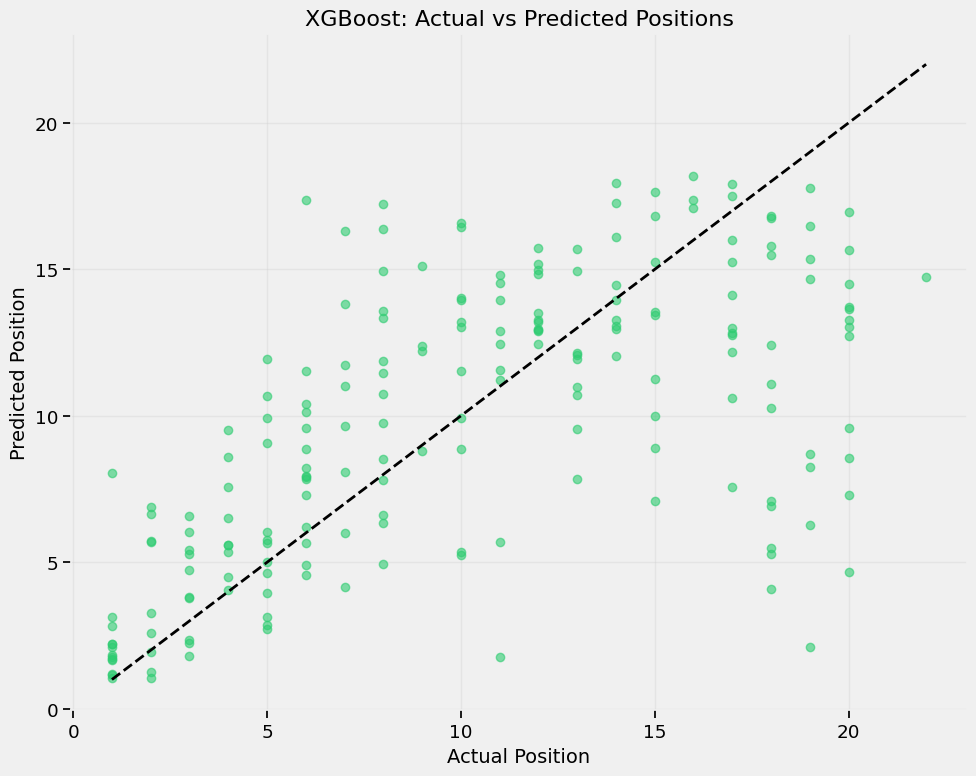

In [21]:
# 4. Actual vs Predicted Positions Scatter Plot
plt.figure(figsize=(10, 8))
plt.scatter(y_pos_test, xgb_position_preds, alpha=0.6, color='#2ecc71')
plt.plot([min(y_pos_test), max(y_pos_test)], [min(y_pos_test), max(y_pos_test)], 'k--', lw=2)  # Perfect prediction line
plt.title('XGBoost: Actual vs Predicted Positions', fontsize=16)
plt.xlabel('Actual Position', fontsize=14)
plt.ylabel('Predicted Position', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('position_predictions.png')
plt.close()

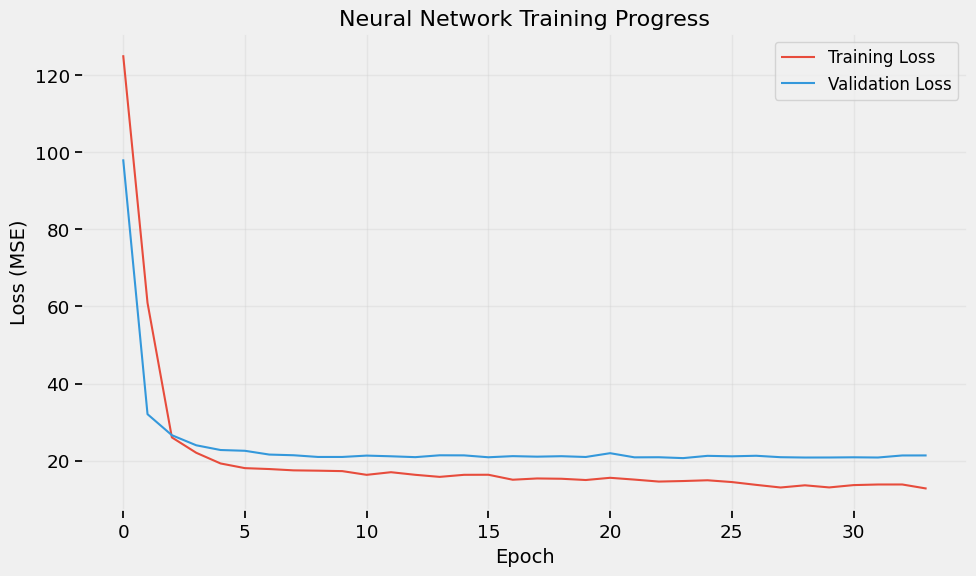

In [22]:
# 5. Neural Network Training History
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='#e74c3c')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#3498db')
plt.title('Neural Network Training Progress', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('nn_training_history.png')
plt.close()

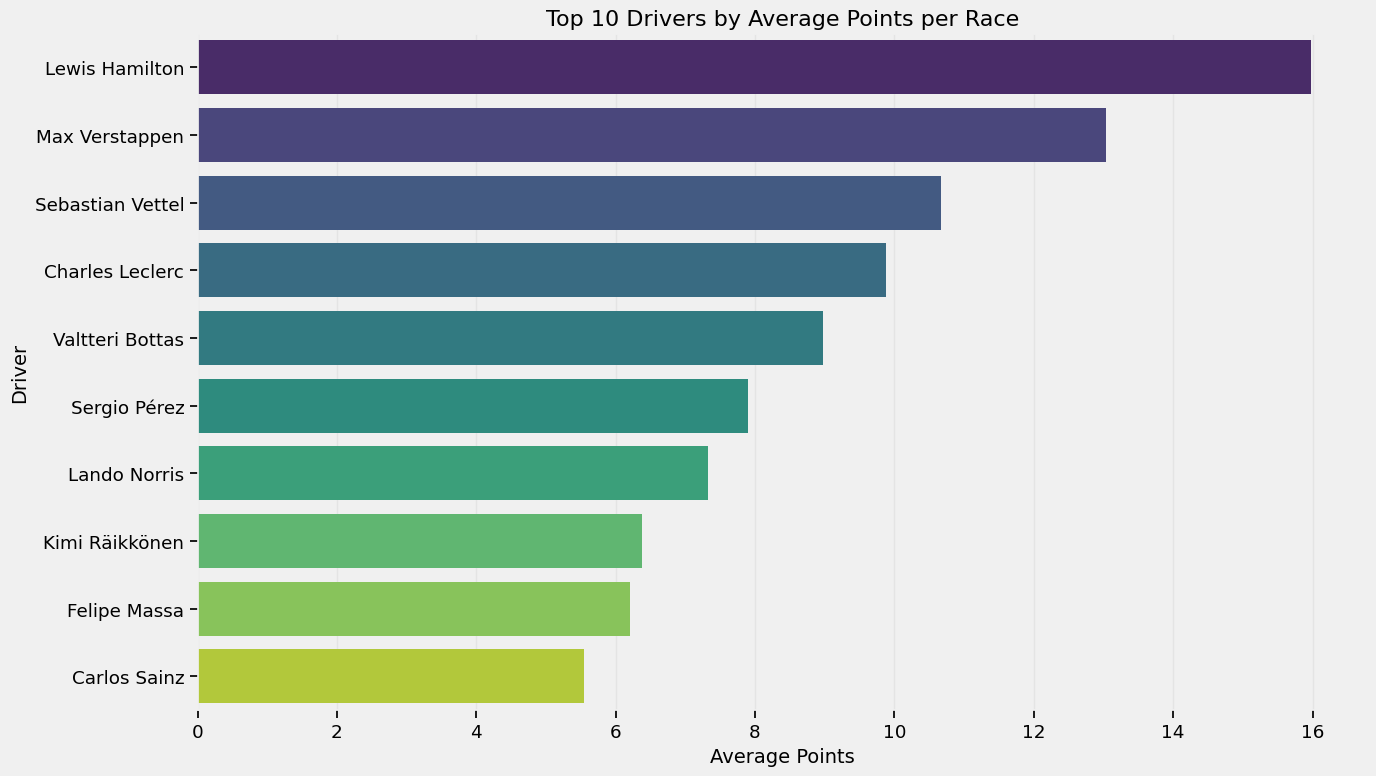

In [23]:
# 6. Top Drivers by Average Points per Race
top_drivers = model_data.groupby('driver_name')['points'].agg(['mean', 'count']).reset_index()
top_drivers = top_drivers[top_drivers['count'] > 10].sort_values('mean', ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(x='mean', y='driver_name', data=top_drivers, palette='viridis')
plt.title('Top 10 Drivers by Average Points per Race', fontsize=16)
plt.xlabel('Average Points', fontsize=14)
plt.ylabel('Driver', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('top_drivers.png')
plt.close()


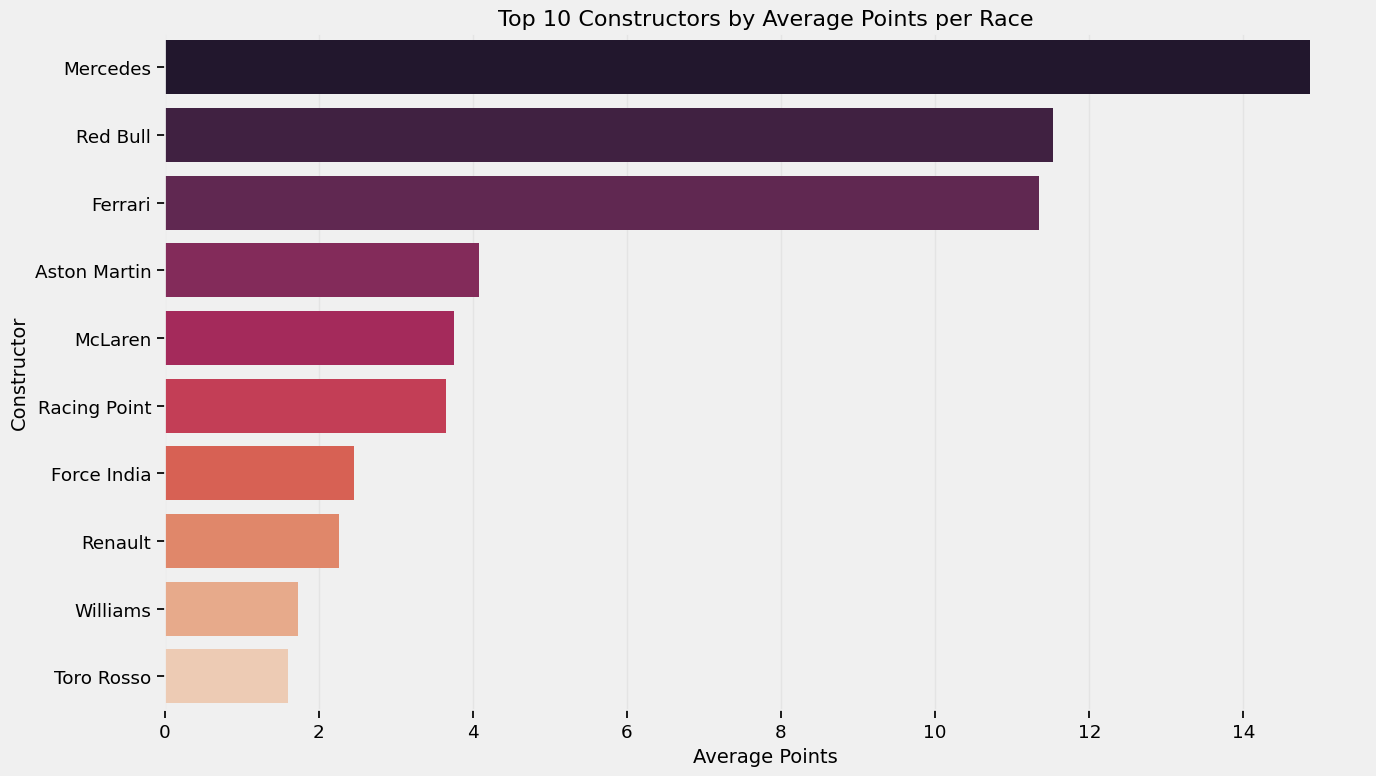

In [24]:
# 7. Constructor Performance
constructor_perf = model_data.groupby('constructor')['points'].mean().reset_index()
constructor_perf = constructor_perf.sort_values('points', ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(x='points', y='constructor', data=constructor_perf, palette='rocket')
plt.title('Top 10 Constructors by Average Points per Race', fontsize=16)
plt.xlabel('Average Points', fontsize=14)
plt.ylabel('Constructor', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('constructor_performance.png')
plt.close()

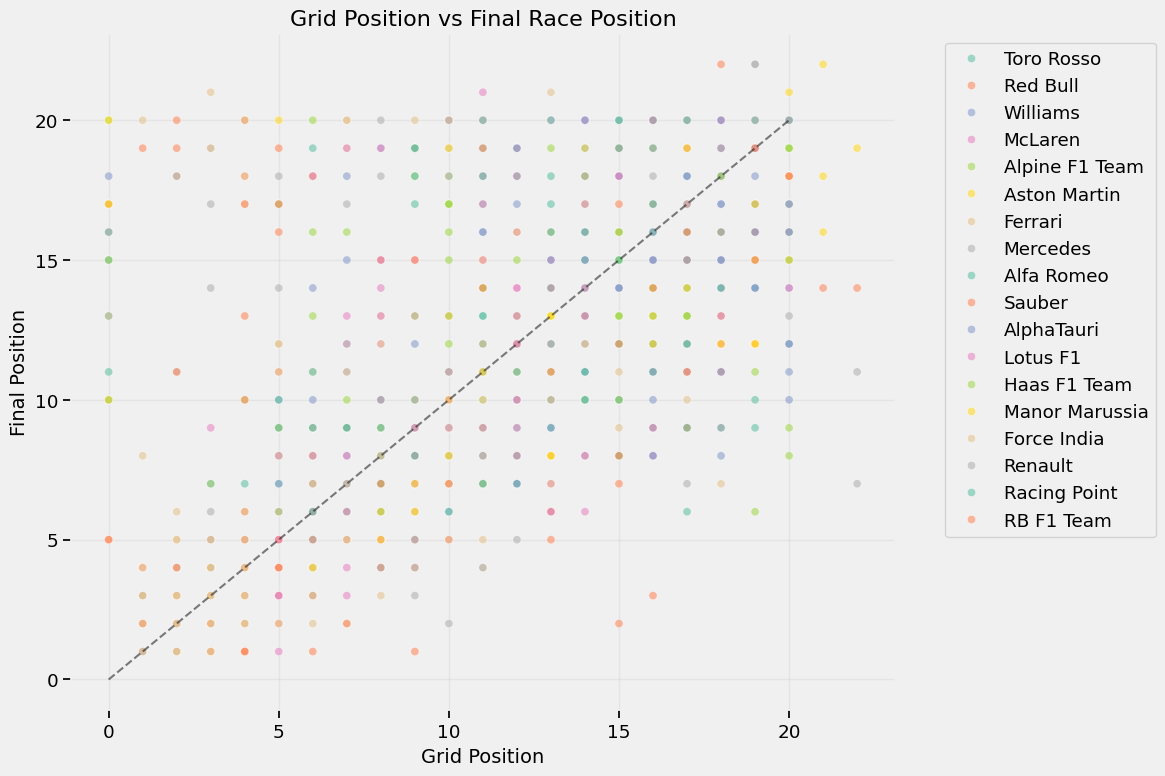

In [25]:
# 8. Grid Position vs Final Position
plt.figure(figsize=(12, 8))
sns.scatterplot(data=model_data, x='grid', y='position', hue='constructor', alpha=0.6, palette='Set2')
plt.plot([0, 20], [0, 20], 'k--', alpha=0.5)  # Line where grid = final position
plt.title('Grid Position vs Final Race Position', fontsize=16)
plt.xlabel('Grid Position', fontsize=14)
plt.ylabel('Final Position', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('grid_vs_position.png')
plt.close()

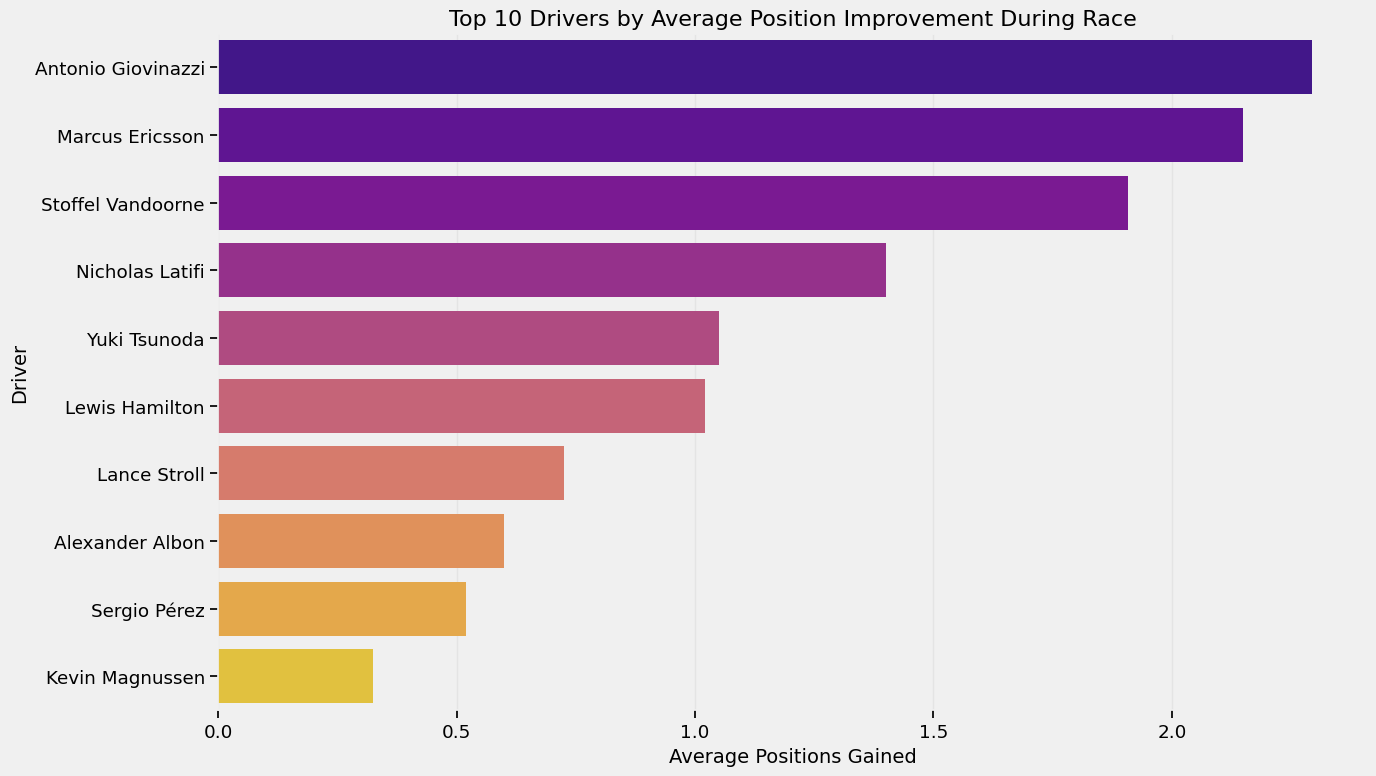

In [26]:
# 9. Position Improvement from Grid
model_data['position_improvement'] = model_data['grid'] - model_data['position']
driver_improvement = model_data.groupby('driver_name')['position_improvement'].agg(['mean', 'count']).reset_index()
driver_improvement = driver_improvement[driver_improvement['count'] > 10].sort_values('mean', ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(x='mean', y='driver_name', data=driver_improvement, palette='plasma')
plt.title('Top 10 Drivers by Average Position Improvement During Race', fontsize=16)
plt.xlabel('Average Positions Gained', fontsize=14)
plt.ylabel('Driver', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('position_improvement.png')
plt.close()

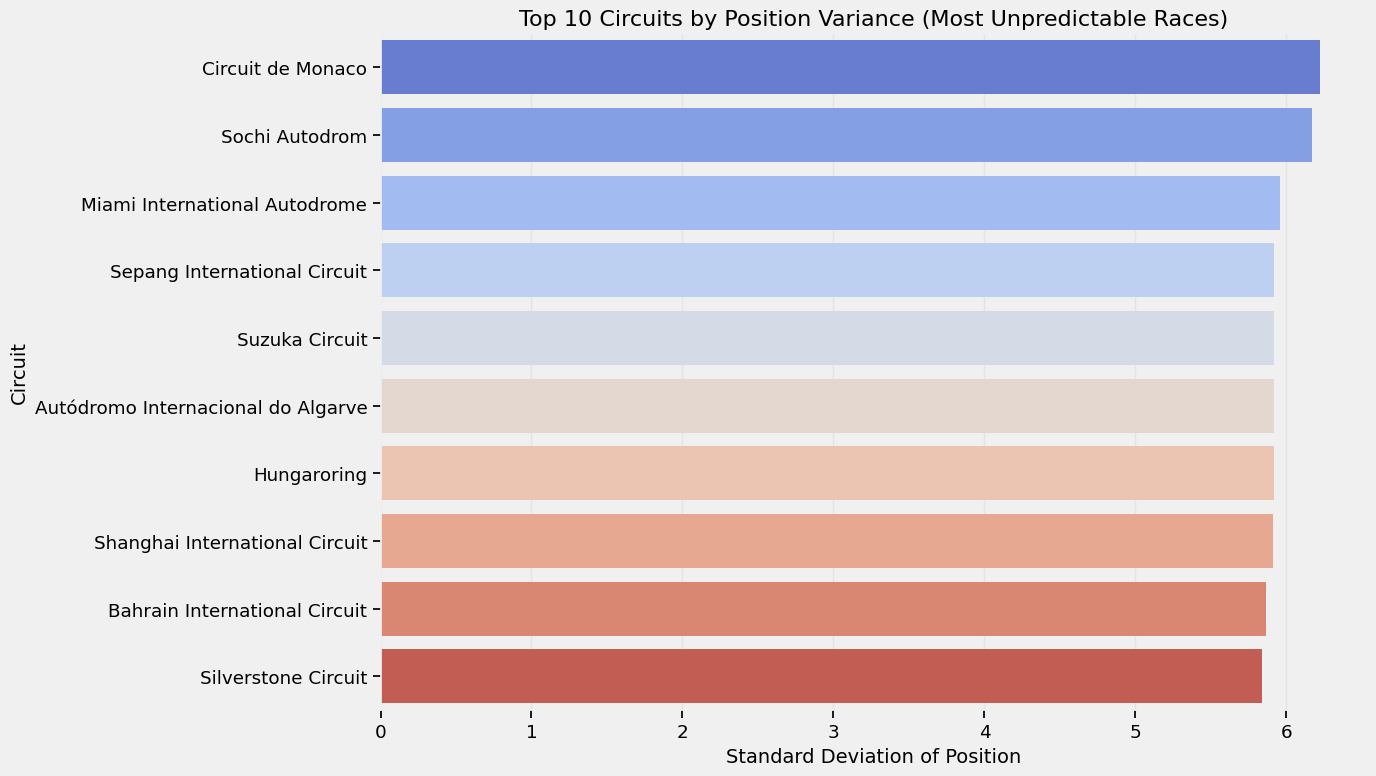

In [27]:
# 10. Circuit Performance Variance
circuit_variance = model_data.groupby('circuit')['position'].std().reset_index()
circuit_variance = circuit_variance.sort_values('position', ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(x='position', y='circuit', data=circuit_variance, palette='coolwarm')
plt.title('Top 10 Circuits by Position Variance (Most Unpredictable Races)', fontsize=16)
plt.xlabel('Standard Deviation of Position', fontsize=14)
plt.ylabel('Circuit', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('circuit_variance.png')
plt.close()

# Race Prediction

In [28]:
# Function to make predictions for a new race
def predict_race_results(model_data, qualifying_results, circuit, season=2024, round_num=1):
    """
    Predict race results based on qualifying data.

    Parameters:
    - model_data: DataFrame, the historical data used to train the models
    - qualifying_results: DataFrame, qualifying results for the race to predict
    - circuit: str, name of the circuit
    - season: int, season year
    - round_num: int, round number in the season

    Returns:
    - DataFrame with predicted positions and points
    """
    # Prepare features for prediction
    prediction_data = []

    for _, quali in qualifying_results.iterrows():
        driver_id = quali['driver_id']
        driver_name = quali['driver_name']
        constructor = quali['constructor']
        q_position = quali['q_position']

        # Get previous performance metrics
        driver_history = model_data[model_data['driver_id'] == driver_id].sort_values('date', ascending=False)

        if len(driver_history) > 0:
            prev_position = driver_history.iloc[0]['position']
            prev_points = driver_history.iloc[0]['points']

            # Average of last 3 races
            recent_races = driver_history.head(3)
            avg_last_3_positions = recent_races['position'].mean()
            avg_last_3_points = recent_races['points'].mean()

            # Circuit familiarity
            circuit_races = len(driver_history[driver_history['circuit'] == circuit])

            # Driver experience
            driver_experience = len(driver_history)

            # DNF rate
            dnf_history = driver_history['status'] != 'Finished'
            dnf_rate = dnf_history.mean() if len(dnf_history) > 0 else 0

            # Constructor performance
            constructor_history = model_data[model_data['constructor'] == constructor].sort_values('date', ascending=False)
            if len(constructor_history) > 0:
                avg_constructor_pos = constructor_history['position'].mean()
                avg_constructor_points = constructor_history['points'].mean()
            else:
                avg_constructor_pos = 10  # default value
                avg_constructor_points = 5  # default value

            # Season progress
            max_rounds = model_data[model_data['season'] == season]['round'].max() if season in model_data['season'].values else 22
            season_progress = round_num / max_rounds
        else:
            # Default values for new drivers
            prev_position = 10
            prev_points = 0
            avg_last_3_positions = 10
            avg_last_3_points = 0
            circuit_races = 0
            driver_experience = 0
            dnf_rate = 0.1

            # Constructor performance - use average if available
            constructor_history = model_data[model_data['constructor'] == constructor].sort_values('date', ascending=False)
            if len(constructor_history) > 0:
                avg_constructor_pos = constructor_history['position'].mean()
                avg_constructor_points = constructor_history['points'].mean()
            else:
                avg_constructor_pos = 10  # default value
                avg_constructor_points = 5  # default value

            season_progress = round_num / 22

        # Create feature row
        feature_row = {
            'driver_id': driver_id,
            'driver_name': driver_name,
            'constructor': constructor,
            'circuit': circuit,
            'grid': q_position,  # Use qualifying position as grid position
            'q_position': q_position,
            'prev_position': prev_position,
            'prev_points': prev_points,
            'avg_last_3_positions': avg_last_3_positions,
            'avg_last_3_points': avg_last_3_points,
            'circuit_races': circuit_races,
            'avg_constructor_pos': avg_constructor_pos,
            'avg_constructor_points': avg_constructor_points,
            'driver_experience': driver_experience,
            'dnf_rate': dnf_rate,
            'season_progress': season_progress,
            'round': round_num
        }

        prediction_data.append(feature_row)

    # Create DataFrame from prediction data
    pred_df = pd.DataFrame(prediction_data)

    # Ensure columns match those used in training
    for col in numerical_features:
        if col not in pred_df.columns:
            pred_df[col] = 0

    # Make predictions
    position_preds = xgb_position_pipeline.predict(pred_df)
    points_preds = xgb_points_pipeline.predict(pred_df)

    # Add predictions to DataFrame
    pred_df['predicted_position'] = position_preds
    pred_df['predicted_points'] = points_preds

    # Sort by predicted position
    pred_df = pred_df.sort_values('predicted_position')

    # Clean up DataFrame for display
    result_df = pred_df[['driver_name', 'constructor', 'grid', 'predicted_position', 'predicted_points']].copy()
    result_df['predicted_position'] = result_df['predicted_position'].round(1)
    result_df['predicted_points'] = result_df['predicted_points'].round(1)



    return result_df


In [29]:
display(model_data.head())      # first 5 rows


,season,race_name,circuit,date,driver_id,driver_name,constructor,grid,position,status,...,circuit_races,avg_constructor_pos,avg_constructor_points,grid_to_position_change,driver_experience,dnf,dnf_rate,round,season_progress,position_improvement
0,2019,Australian Grand Prix,Albert Park Grand Prix Circuit,2019-03-17,albon,Alexander Albon,Toro Rosso,13,14,+1 Lap,...,2.0,12.4,0.6,-1,14.5,1,0.500000,1,0.2,-1
1,2019,Bahrain Grand Prix,Bahrain International Circuit,2019-03-31,albon,Alexander Albon,Toro Rosso,12,9,Finished,...,2.0,12.4,0.6,3,1.0,0,1.000000,2,0.4,3
2,2019,Chinese Grand Prix,Shanghai International Circuit,2019-04-14,albon,Alexander Albon,Toro Rosso,0,10,+1 Lap,...,2.0,12.4,0.6,-10,2.0,1,0.500000,3,0.6,-10
3,2019,Azerbaijan Grand Prix,Baku City Circuit,2019-04-28,albon,Alexander Albon,Toro Rosso,11,11,+1 Lap,...,2.0,12.4,0.6,0,3.0,1,0.666667,4,0.8,0
4,2019,Spanish Grand Prix,Circuit de Barcelona-Catalunya,2019-05-12,albon,Alexander Albon,Toro Rosso,11,11,Finished,...,2.0,12.4,0.6,0,4.0,0,0.750000,5,1.0,0



Demonstrating race prediction functionality...

Predicted Race Results for Monaco Grand Prix 2024:
       driver_name   constructor  grid  predicted_position  predicted_points
6     Carlos Sainz       Ferrari     7                 4.9         14.000000
7     Sergio Perez      Red Bull     8                 5.3         12.900000
3   Lewis Hamilton      Mercedes     4                 6.1         12.600000
4   George Russell      Mercedes     5                 6.2         12.300000
5    Oscar Piastri       McLaren     6                 8.0         10.000000
8  Fernando Alonso  Aston Martin     9                10.6          6.000000
1  Charles Leclerc       Ferrari     2                10.7         15.000000
0   Max Verstappen      Red Bull     1                11.9         18.700001
9     Lance Stroll  Aston Martin    10                12.1          3.200000
2     Lando Norris       McLaren     3                14.0          5.300000


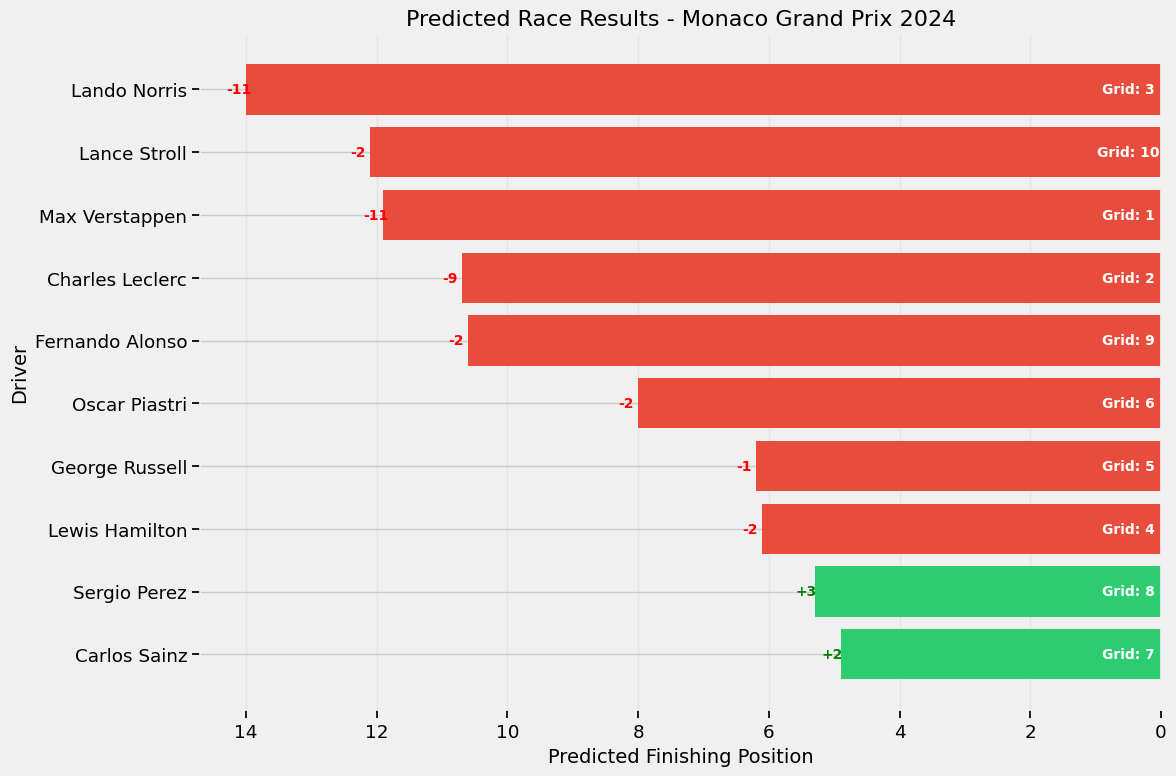

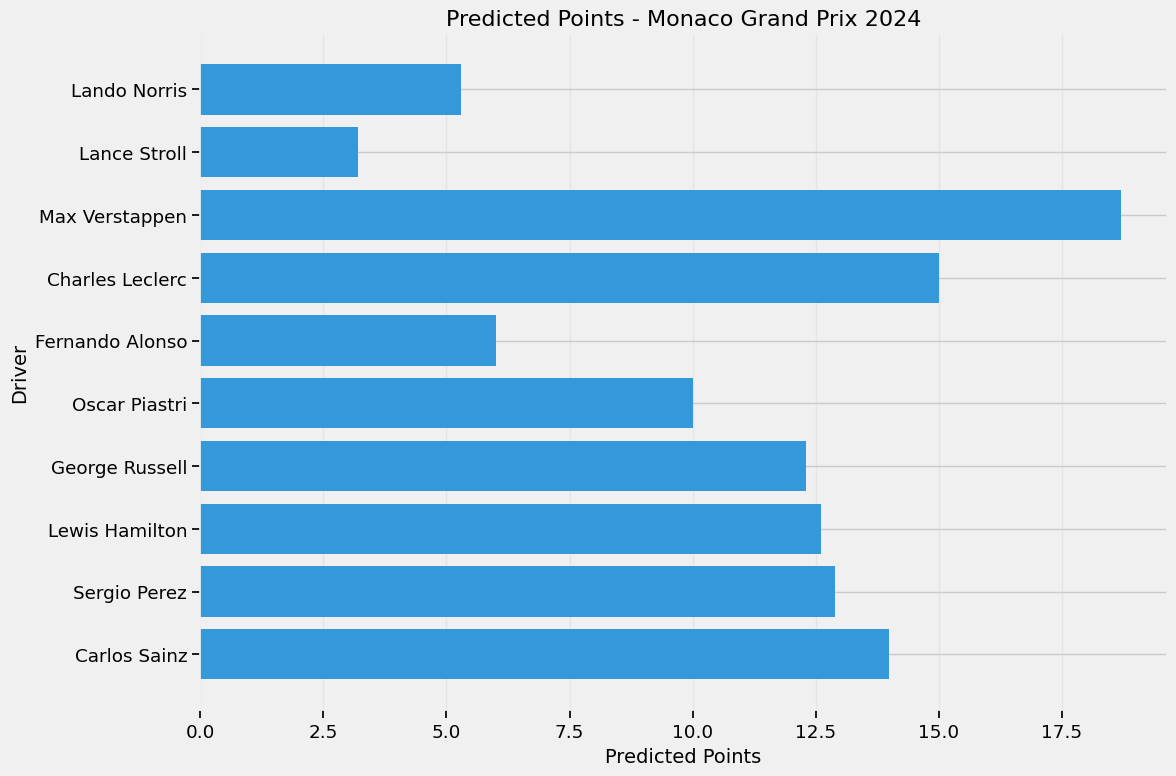

In [30]:
# Example: Predict race results using sample qualifying data
def demonstrate_race_prediction():
    """
    Demonstrate race prediction functionality with sample qualifying data
    """
    print("\nDemonstrating race prediction functionality...")

    # Create sample qualifying data (this would normally come from real data)
    sample_qualifying = pd.DataFrame({
        'driver_id': ['max_verstappen', 'leclerc', 'norris', 'hamilton', 'russell', 'piastri',
                     'sainz', 'perez', 'alonso', 'stroll'],
        'driver_name': ['Max Verstappen', 'Charles Leclerc', 'Lando Norris', 'Lewis Hamilton',
                       'George Russell', 'Oscar Piastri', 'Carlos Sainz', 'Sergio Perez',
                       'Fernando Alonso', 'Lance Stroll'],
        'constructor': ['Red Bull', 'Ferrari', 'McLaren', 'Mercedes', 'Mercedes', 'McLaren',
                       'Ferrari', 'Red Bull', 'Aston Martin', 'Aston Martin'],
        'q_position': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    })
    # Make predictions for a sample race
    sample_circuit = 'Circuit de Monaco'
    race_predictions = predict_race_results(model_data, sample_qualifying, sample_circuit, season=2024, round_num=7)

    print("\nPredicted Race Results for Monaco Grand Prix 2024:")
    print(race_predictions)

    # Visualize the predictions
    plt.figure(figsize=(12, 8))

    # Create position change arrows
    race_predictions['position_change'] = race_predictions['grid'] - race_predictions['predicted_position']

    # Determine color based on position change
    colors = race_predictions['position_change'].apply(
        lambda x: '#2ecc71' if x > 0 else '#e74c3c' if x < 0 else '#3498db'
    )
     # Plot predicted positions
    plt.barh(race_predictions['driver_name'], race_predictions['predicted_position'], color=colors)

    # Add grid position as text
    for i, (_, row) in enumerate(race_predictions.iterrows()):
        plt.text(
            0.5, i,
            f"Grid: {int(row['grid'])}",
            ha='center', va='center',
            fontsize=10, color='white', fontweight='bold'
        )

        # Add arrows or text showing position change
        if row['position_change'] != 0:
            change_text = f"{'+' if row['position_change'] > 0 else ''}{row['position_change']:.0f}"
            plt.text(
                row['predicted_position'] + 0.3, i,
                change_text,
                ha='left', va='center',
                fontsize=10, fontweight='bold',
                color='green' if row['position_change'] > 0 else 'red'
            )

    plt.title(f'Predicted Race Results - Monaco Grand Prix 2024', fontsize=16)
    plt.xlabel('Predicted Finishing Position', fontsize=14)
    plt.ylabel('Driver', fontsize=14)
    plt.gca().invert_xaxis()  # Invert x-axis so position 1 is on the right
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.savefig('predicted_race_results.png')
    plt.close()

    # Visualize predicted points
    plt.figure(figsize=(12, 8))
    plt.barh(race_predictions['driver_name'], race_predictions['predicted_points'], color='#3498db')
    plt.title(f'Predicted Points - Monaco Grand Prix 2024', fontsize=16)
    plt.xlabel('Predicted Points', fontsize=14)
    plt.ylabel('Driver', fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.savefig('predicted_points.png')
    plt.close()

    return race_predictions

# Run prediction demonstration
race_predictions = demonstrate_race_prediction()

In [31]:

# Model Ensemble

# Create a simple ensemble of models
def ensemble_predict(X, models, weights=None):
    """
    Create an ensemble prediction from multiple models.

    Parameters:
    - X: Features to predict on
    - models: List of trained models
    - weights: List of weights for each model (default: equal weights)

    Returns:
    - Weighted average predictions
    """
    if weights is None:
        weights = [1/len(models)] * len(models)

    predictions = np.zeros(len(X))

    for model, weight in zip(models, weights):
        if isinstance(model, Pipeline):
            preds = model.predict(X)
        else:  # Neural Network
            X_processed = preprocessor.transform(X)
            preds = model.predict(X_processed).flatten()

        predictions += weight * preds

    return predictions


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Ensemble Model Position RMSE: 4.5455


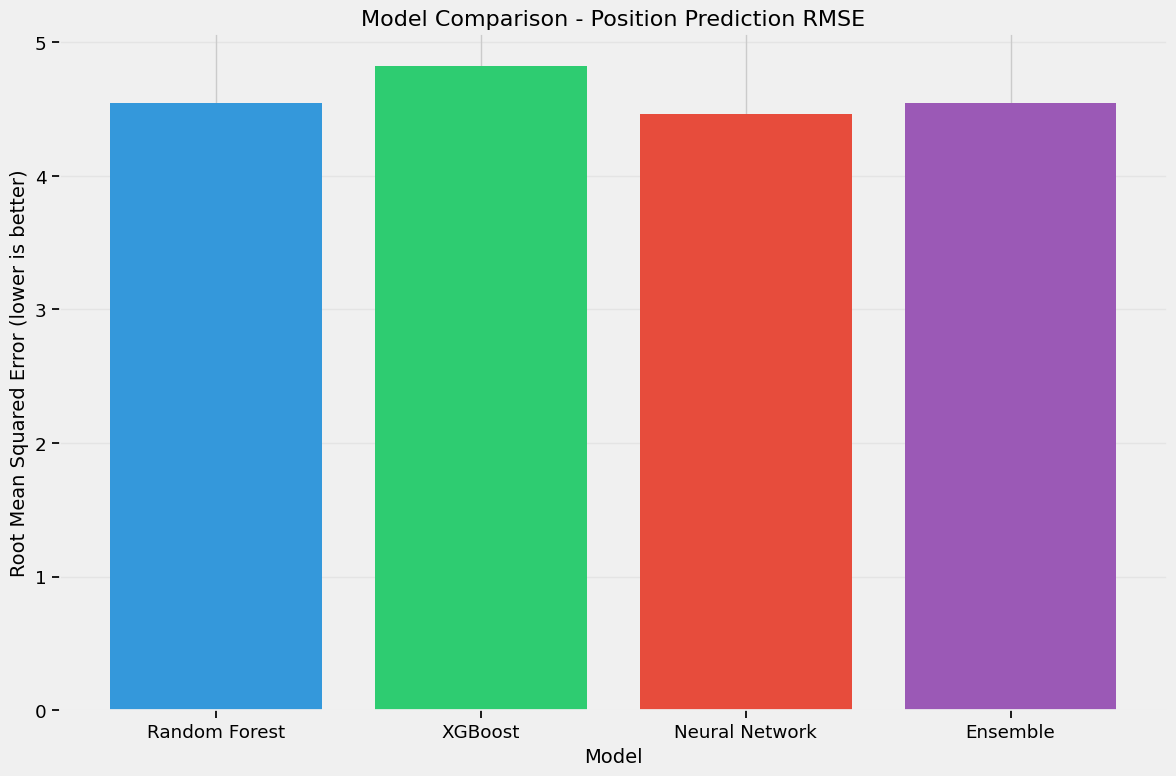

In [32]:
# Create ensemble using all models
models = [rf_position_pipeline, xgb_position_pipeline, nn_model]
weights = [0.3, 0.4, 0.3]  # Weights based on model performance

# Test ensemble on test data
ensemble_preds = ensemble_predict(X_test, models, weights)
ensemble_rmse = np.sqrt(mean_squared_error(y_pos_test, ensemble_preds))
print(f"Ensemble Model Position RMSE: {ensemble_rmse:.4f}")

# Add ensemble model to comparison
plt.figure(figsize=(12, 8))
model_names = ['Random Forest', 'XGBoost', 'Neural Network', 'Ensemble']
position_rmse = [rf_position_rmse, xgb_position_rmse, nn_position_rmse, ensemble_rmse]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

plt.bar(model_names, position_rmse, color=colors)
plt.title('Model Comparison - Position Prediction RMSE', fontsize=16)
plt.ylabel('Root Mean Squared Error (lower is better)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('ensemble_comparison.png')
plt.close()


Demonstrating driver comparison functionality...

Driver Comparison: Max Verstappen vs Lewis Hamilton
           Driver  Races  Avg Position  Avg Points  Avg Grid  Avg Pos Gain  \
0  Max Verstappen     50          6.66       13.04      5.14         -1.52   
1  Lewis Hamilton     49          3.71       15.98      4.73          1.02   

   DNF Rate  
0      0.26  
1      0.04  


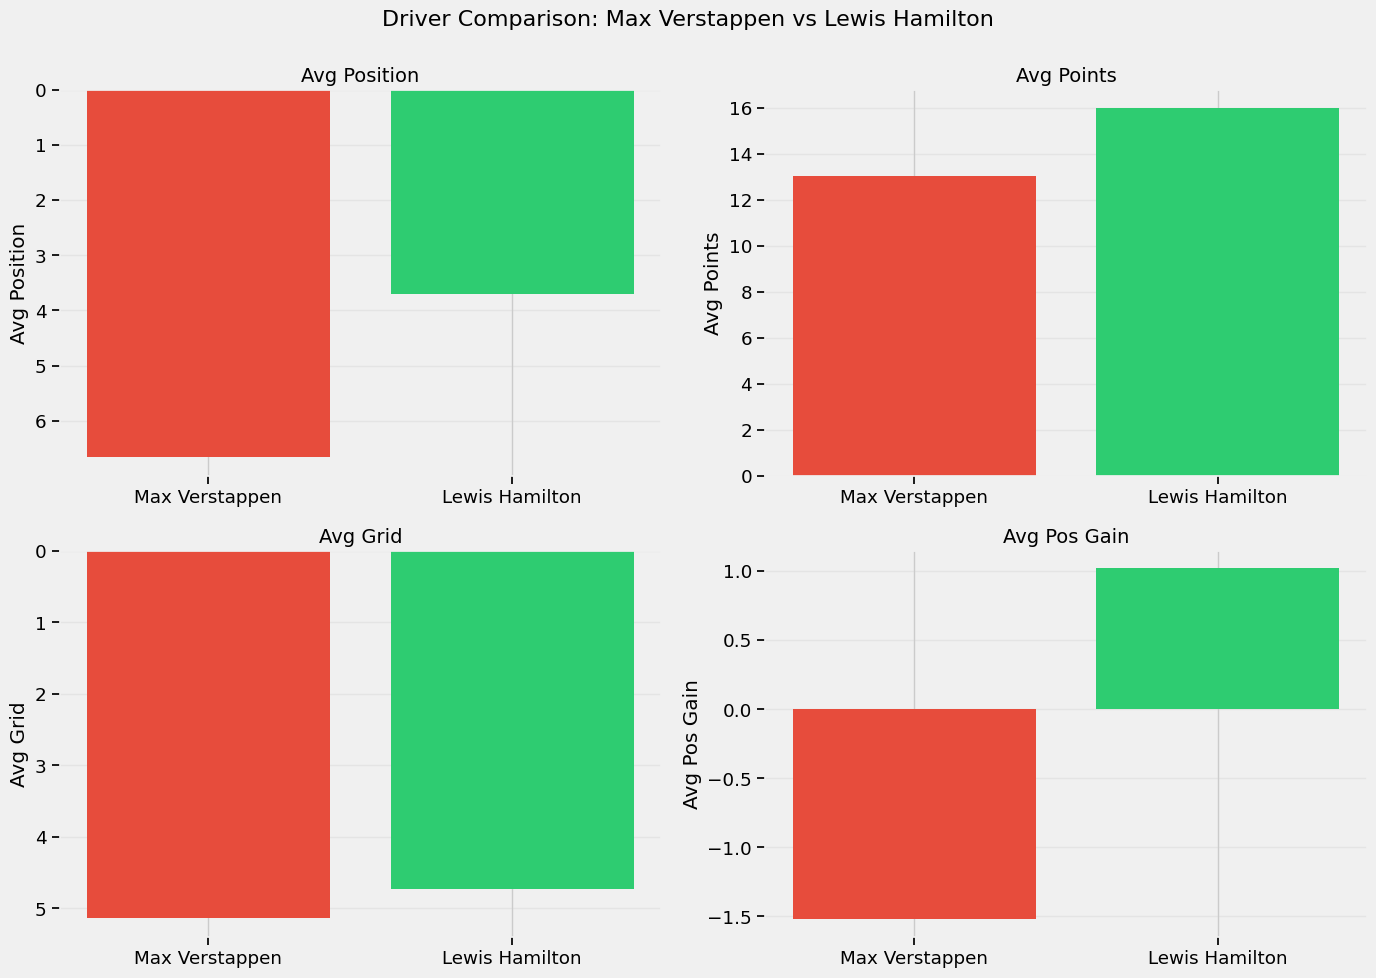

In [33]:
# Driver Head-to-Head Comparison Tool
def compare_drivers(model_data, driver1, driver2):
    """
    Compare performance metrics between two drivers.

    Parameters:
    - model_data: DataFrame with race data
    - driver1: Name of first driver to compare
    - driver2: Name of second driver to compare

    Returns:
    - DataFrame with comparison metrics
    """
    driver1_data = model_data[model_data['driver_name'] == driver1]
    driver2_data = model_data[model_data['driver_name'] == driver2]

    # Calculate metrics
    metrics = {
        'Driver': [driver1, driver2],
        'Races': [len(driver1_data), len(driver2_data)],
        'Avg Position': [driver1_data['position'].mean(), driver2_data['position'].mean()],
        'Avg Points': [driver1_data['points'].mean(), driver2_data['points'].mean()],
        'Avg Grid': [driver1_data['grid'].mean(), driver2_data['grid'].mean()],
        'Avg Pos Gain': [
            (driver1_data['grid'] - driver1_data['position']).mean(),
            (driver2_data['grid'] - driver2_data['position']).mean()
        ],
        'DNF Rate': [
            (driver1_data['status'] != 'Finished').mean(),
            (driver2_data['status'] != 'Finished').mean()
        ]
    }

    comparison_df = pd.DataFrame(metrics)

    # Round numerical values
    for col in comparison_df.columns:
        if col != 'Driver' and col != 'Races':
            comparison_df[col] = comparison_df[col].round(2)

    return comparison_df

# Demonstrate driver comparison
print("\nDemonstrating driver comparison functionality...")
driver_comparison = compare_drivers(model_data, 'Max Verstappen', 'Lewis Hamilton')
print("\nDriver Comparison: Max Verstappen vs Lewis Hamilton")
print(driver_comparison)

# Visualize driver comparison
metrics_to_plot = ['Avg Position', 'Avg Points', 'Avg Grid', 'Avg Pos Gain']
driver1, driver2 = driver_comparison['Driver']

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i+1)
    data = driver_comparison[metric].tolist()

    # For position and grid, lower is better
    if metric in ['Avg Position', 'Avg Grid']:
        colors = ['#2ecc71' if data[0] < data[1] else '#e74c3c',
                  '#2ecc71' if data[1] < data[0] else '#e74c3c']
        plt.gca().invert_yaxis()  # Invert y-axis for position metrics
    else:
        colors = ['#2ecc71' if data[0] > data[1] else '#e74c3c',
                  '#2ecc71' if data[1] > data[0] else '#e74c3c']

    plt.bar([driver1, driver2], data, color=colors)
    plt.title(metric, fontsize=14)
    plt.ylabel(metric)
    plt.grid(axis='y', alpha=0.3)

plt.suptitle(f'Driver Comparison: {driver1} vs {driver2}', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
plt.savefig('driver_comparison.png')
plt.close()

#Analysing the best stop stratergy

In [34]:
# Race Strategy Simulation
def simulate_race_strategy(grid_position, avg_overtake_difficulty=0.7, pit_stop_time=25,
                           tire_deg_factor=0.05, num_laps=60):
    """
    Simple simulation of race strategy (one-stop vs two-stop).

    Parameters:
    - grid_position: Starting position on the grid
    - avg_overtake_difficulty: Factor representing difficulty to overtake (0-1)
    - pit_stop_time: Time lost in the pits in seconds
    - tire_deg_factor: How much time is lost per lap due to tire degradation
    - num_laps: Total race laps

    Returns:
    - Dictionary with strategy simulation results
    """
    # Initialize strategies
    one_stop = {
        'name': '1-stop',
        'position': grid_position,
        'total_time': 0,
        'tire_age': 0,
        'pit_stops': 0,
        'position_history': [grid_position],
        'time_history': [0]
    }

    two_stop = {
        'name': '2-stop',
        'position': grid_position,
        'total_time': 0,
        'tire_age': 0,
        'pit_stops': 0,
        'position_history': [grid_position],
        'time_history': [0]
    }

    # One-stop strategy: pit around lap num_laps/2
    one_stop_pit_lap = int(num_laps / 2)

    # Two-stop strategy: pit around lap num_laps/3 and 2*num_laps/3
    two_stop_pit_lap1 = int(num_laps / 3)
    two_stop_pit_lap2 = int(2 * num_laps / 3)

    # Simulate each lap
    for lap in range(1, num_laps + 1):
        # Update tire age
        one_stop['tire_age'] += 1
        two_stop['tire_age'] += 1

        # Base lap time (1:30 = 90 seconds) + tire degradation
        one_stop_lap_time = 90 + (one_stop['tire_age'] * tire_deg_factor)
        two_stop_lap_time = 90 + (two_stop['tire_age'] * tire_deg_factor)

        # Apply pit stops
        if lap == one_stop_pit_lap:
            one_stop['total_time'] += one_stop_lap_time + pit_stop_time
            one_stop['tire_age'] = 0
            one_stop['pit_stops'] += 1
            # Lose positions in the pit
            pit_positions_lost = min(3, one_stop['position'])
            one_stop['position'] += pit_positions_lost
        else:
            one_stop['total_time'] += one_stop_lap_time

        if lap == two_stop_pit_lap1 or lap == two_stop_pit_lap2:
            two_stop['total_time'] += two_stop_lap_time + pit_stop_time
            two_stop['tire_age'] = 0
            two_stop['pit_stops'] += 1
            # Lose positions in the pit
            pit_positions_lost = min(3, two_stop['position'])
            two_stop['position'] += pit_positions_lost
        else:
            two_stop['total_time'] += two_stop_lap_time

        # Potential overtaking due to fresher tires
        # More overtaking potential with fresher tires
        one_stop_overtake_potential = max(0, (1 - one_stop['tire_age'] * 0.02))
        two_stop_overtake_potential = max(0, (1 - two_stop['tire_age'] * 0.02))

        # Chance to overtake depends on tire freshness and track difficulty
        one_stop_overtake_chance = one_stop_overtake_potential * (1 - avg_overtake_difficulty)
        two_stop_overtake_chance = two_stop_overtake_potential * (1 - avg_overtake_difficulty)

        # Apply overtaking
        if one_stop['position'] > 1 and np.random.random() < one_stop_overtake_chance:
            one_stop['position'] -= 1

        if two_stop['position'] > 1 and np.random.random() < two_stop_overtake_chance:
            two_stop['position'] -= 1

        # Record history
        one_stop['position_history'].append(one_stop['position'])
        one_stop['time_history'].append(one_stop['total_time'])

        two_stop['position_history'].append(two_stop['position'])
        two_stop['time_history'].append(two_stop['total_time'])

    # Compare final results
    results = {
        'one_stop': {
            'final_position': one_stop['position'],
            'total_time': one_stop['total_time'],
            'position_history': one_stop['position_history'],
            'time_history': one_stop['time_history']
        },
        'two_stop': {
            'final_position': two_stop['position'],
            'total_time': two_stop['total_time'],
            'position_history': two_stop['position_history'],
            'time_history': two_stop['time_history']
        },
        'best_strategy': '1-stop' if one_stop['position'] < two_stop['position'] else '2-stop'
    }

    return results

In [35]:
# Demonstrate race strategy simulation
print("\nDemonstrating race strategy simulation...")
grid_pos = 5
track_difficulty = 0.8  # Monaco-like, difficult to overtake
strategy_sim = simulate_race_strategy(grid_pos, avg_overtake_difficulty=track_difficulty)

print(f"\nRace Strategy Simulation for Starting Grid Position {grid_pos}:")
print(f"One Stop - Final Position: {strategy_sim['one_stop']['final_position']}")
print(f"Two Stop - Final Position: {strategy_sim['two_stop']['final_position']}")
print(f"Best Strategy: {strategy_sim['best_strategy']}")


Demonstrating race strategy simulation...

Race Strategy Simulation for Starting Grid Position 5:
One Stop - Final Position: 1
Two Stop - Final Position: 1
Best Strategy: 2-stop


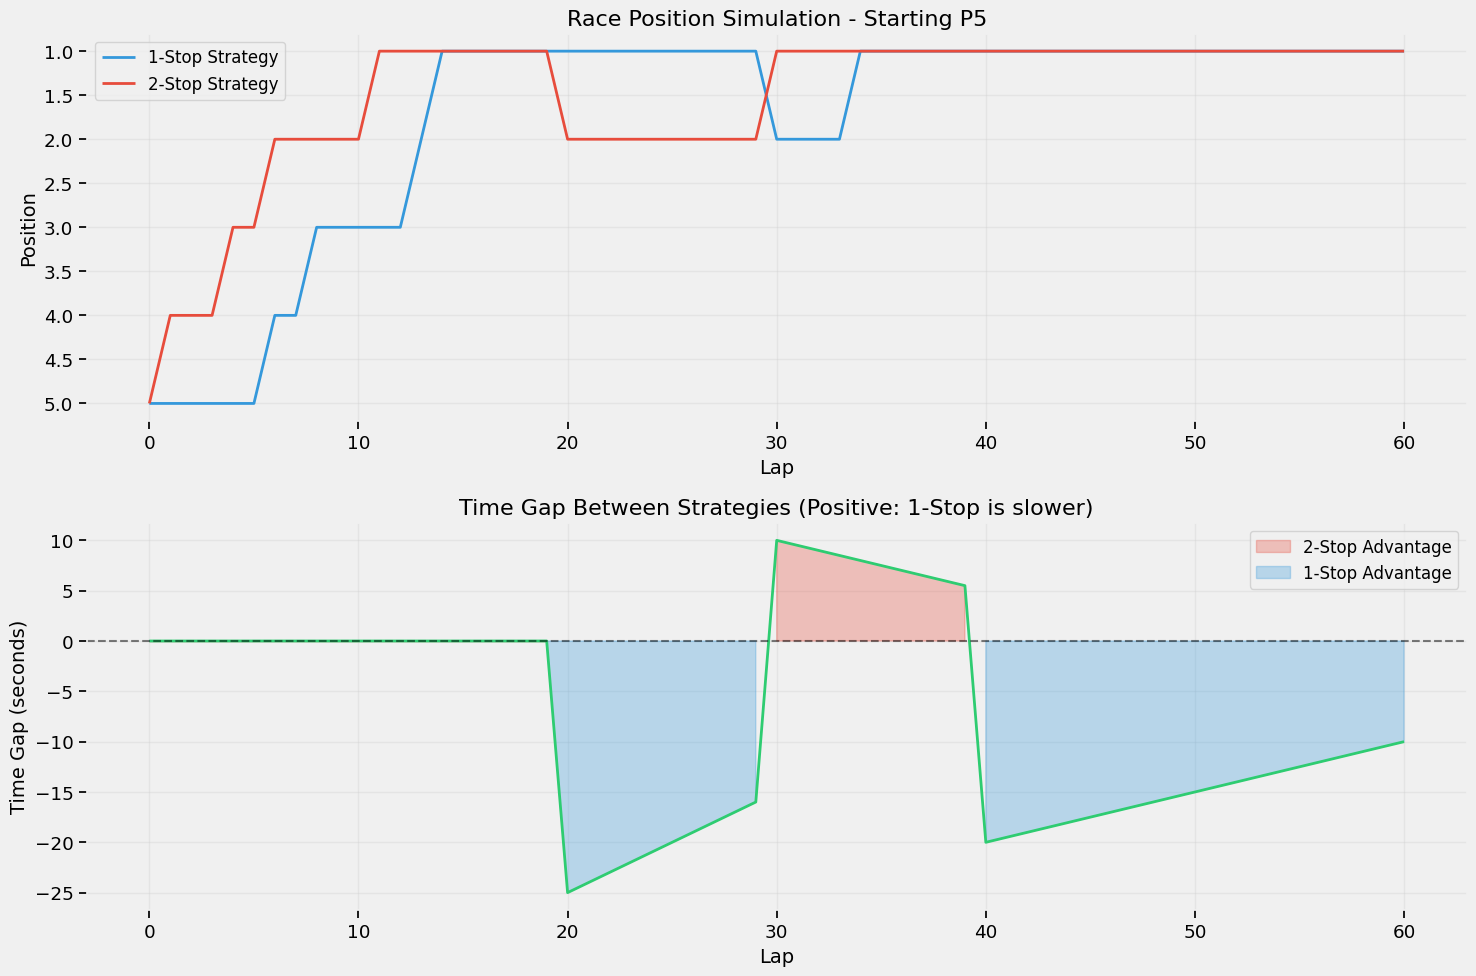

In [36]:

# Visualize strategy simulation
plt.figure(figsize=(15, 10))

# Plot position histories
plt.subplot(2, 1, 1)
plt.plot(strategy_sim['one_stop']['position_history'], label='1-Stop Strategy', color='#3498db', linewidth=2)
plt.plot(strategy_sim['two_stop']['position_history'], label='2-Stop Strategy', color='#e74c3c', linewidth=2)
plt.title(f'Race Position Simulation - Starting P{grid_pos}', fontsize=16)
plt.xlabel('Lap', fontsize=14)
plt.ylabel('Position', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis so higher positions are at the top
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Plot time gap
plt.subplot(2, 1, 2)
time_diff = np.array(strategy_sim['one_stop']['time_history']) - np.array(strategy_sim['two_stop']['time_history'])
plt.plot(time_diff, color='#2ecc71', linewidth=2)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.fill_between(range(len(time_diff)), time_diff, 0, where=(time_diff >= 0),
                 color='#e74c3c', alpha=0.3, label='2-Stop Advantage')
plt.fill_between(range(len(time_diff)), time_diff, 0, where=(time_diff <= 0),
                 color='#3498db', alpha=0.3, label='1-Stop Advantage')
plt.title('Time Gap Between Strategies (Positive: 1-Stop is slower)', fontsize=16)
plt.xlabel('Lap', fontsize=14)
plt.ylabel('Time Gap (seconds)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()
plt.savefig('strategy_simulation.png')
plt.close()



# Prediction of a perticular round in a race

In [37]:
# --- Example: Get a race prediction ---

# 1. Specify season and round number
season    = 2024
round_num = 7

# 2. Fetch the qualifying results for that round
qualifying_df = get_qualifying_results(season, round_num)

# 3. Identify the circuit name (must match how it appears in model_data)
#    e.g. for Monaco:
circuit_name = 'Circuit de Monaco'

# 4. Call the prediction function
predictions = predict_race_results(
    model_data,
    qualifying_df,
    circuit    = circuit_name,
    season     = season,
    round_num  = round_num
)

# 5. View the table of predicted finishing positions and points
print(predictions)

# 6. (Optional) Save to CSV
predictions.to_csv(f'predictions_{season}_round{round_num}.csv', index=False)


         driver_name     constructor  grid  predicted_position  \
4       Carlos Sainz         Ferrari     5                 3.5   
3    Charles Leclerc         Ferrari     4                 4.8   
10      Sergio Pérez        Red Bull    11                 5.0   
5     George Russell        Mercedes     6                 6.0   
7     Lewis Hamilton        Mercedes     8                 6.6   
1      Oscar Piastri         McLaren     2                 8.3   
6       Yuki Tsunoda      RB F1 Team     7                10.6   
12      Lance Stroll    Aston Martin    13                11.8   
0     Max Verstappen        Red Bull     1                11.9   
8   Daniel Ricciardo      RB F1 Team     9                12.3   
11      Esteban Ocon  Alpine F1 Team    12                12.3   
18   Fernando Alonso    Aston Martin    19                12.6   
14      Pierre Gasly  Alpine F1 Team    15                12.8   
13   Alexander Albon        Williams    14                13.1   
16       G

# Prediction of 2022 Bahrain Grand Prix

In [38]:
# --- Batch‐predict an entire season ---

import pandas as pd

season = 2022
season_schedule = race_info[race_info['season'] == season][['round','race_name','circuit_name']]

all_preds = []

for _, row in season_schedule.iterrows():
    rnd       = row['round']
    circuit   = row['circuit_name']
    race_name = row['race_name']

    # 2. Fetch qualifying data for this round
    qual_df = get_qualifying_results(season, rnd)
    if qual_df.empty:
        print(f" No qualifying data for round {rnd}")
        continue

    # 3. Predict
    preds = predict_race_results(
        model_data,
        qual_df,
        circuit    = circuit,
        season     = season,
        round_num  = rnd
    )

    # 4. Tag and collect
    preds['round']     = rnd
    preds['race_name'] = race_name
    all_preds.append(preds)

# 5. Combine and save
all_preds_df = pd.concat(all_preds, ignore_index=True)
print(all_preds_df.head())
all_preds_df.to_csv(f'season_{season}_predictions.csv', index=False)


       driver_name constructor  grid  predicted_position  predicted_points  \
0     Sergio Pérez    Red Bull     4                 4.1              16.5   
1     Carlos Sainz     Ferrari     3                 4.4              12.9   
2   Lewis Hamilton    Mercedes     5                 5.9               9.5   
3  Charles Leclerc     Ferrari     1                 6.5              12.6   
4   George Russell    Mercedes     9                 6.6               8.9   

   round           race_name  
0      1  Bahrain Grand Prix  
1      1  Bahrain Grand Prix  
2      1  Bahrain Grand Prix  
3      1  Bahrain Grand Prix  
4      1  Bahrain Grand Prix  
